In [1]:
#    The customer has limited data available on the Domestic Hot Water (DHW) system of the shopping center they manage.
#    At present, they can only provide information on the overall area of the premises and temperature readings from a few
#    specific hot water supply and return branches. Despite these data limitations, the objective is to offer potential
#    recommendations for enhancing effectiveness of the sistem.

In [2]:
# Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
# Read CSV-file
path = 'DHW.csv'
data = pd.read_csv(path, parse_dates=['Time'], dayfirst=True)

In [4]:
# Check the shape of the DataFrame (number of rows and columns)
print('Shape:', data.shape)

Shape: (674, 15)


In [5]:
# Check the dataset
data.head(5)

,Value1,Value2,Value3,Value4,Value5,Value6,Value7,Time,Side1,Side2,Side3,Side4,Side5,Side6,Side7
0,32.10,36.85,49.65,40.02,50.62,28.90,14.10,2023-06-30 16:50:00,return,return,return,supply,supply,return,supply
1,50.27,28.95,14.20,32.00,38.20,49.10,39.70,2023-06-30 17:05:00,supply,return,supply,return,return,return,supply
2,31.77,39.02,49.05,39.95,49.10,28.92,14.27,2023-06-30 17:20:00,return,return,return,supply,supply,return,supply
3,14.30,31.55,39.40,50.20,39.82,52.85,28.90,2023-06-30 17:35:00,supply,return,return,return,supply,supply,return
4,39.47,50.37,39.80,52.50,28.92,14.40,31.47,2023-06-30 17:50:00,return,return,supply,supply,return,supply,return


In [6]:
# To effectively manage this data, it should be sorted based on the descriptions (return/supply)
# and their corresponding temperatures. It will be reshape by the melt function.

In [7]:
# Reshape by side: return or supply
melted_data_by_side = pd.melt(data, id_vars=['Time'], value_vars=['Side{}'.format(i) for i in range(1, 8)])
melt_side = melted_data_by_side.replace('Side', 'observation', regex=True).sort_values(['Time', 'variable'])
melt_side.head(7)

,Time,variable,value
0,2023-06-30 16:50:00,observation1,return
674,2023-06-30 16:50:00,observation2,return
1348,2023-06-30 16:50:00,observation3,return
2022,2023-06-30 16:50:00,observation4,supply
2696,2023-06-30 16:50:00,observation5,supply
3370,2023-06-30 16:50:00,observation6,return
4044,2023-06-30 16:50:00,observation7,supply


In [8]:
# Reshape by temperature value
melted_data_by_value = pd.melt(data, id_vars=['Time'], value_vars=['Value{}'.format(i) for i in range(1, 8)])
melt_value = melted_data_by_value.replace('Value', 'observation', regex=True).sort_values(['Time', 'variable'])
melt_value.head(7)

,Time,variable,value
0,2023-06-30 16:50:00,observation1,32.10
674,2023-06-30 16:50:00,observation2,36.85
1348,2023-06-30 16:50:00,observation3,49.65
2022,2023-06-30 16:50:00,observation4,40.02
2696,2023-06-30 16:50:00,observation5,50.62
3370,2023-06-30 16:50:00,observation6,28.90
4044,2023-06-30 16:50:00,observation7,14.10


In [9]:
# Merge two melted tables
merged_df = melt_side.merge(melt_value, how='left', on=['Time', 'variable'], suffixes=['_side', '_temp'])

# Sort values by time, side and temperature respectively
merged_sorted_df = merged_df.sort_values(['Time', 'value_side', 'value_temp']).drop('variable', axis=1).reset_index(drop=True)

# Rename columns
merged_sorted_df.columns = ['time', 'side', 'temp']

# Add numbering of one timestamp
merged_sorted_df['sensor'] = (merged_sorted_df.index % 7) + 1
merged_sorted_df.head(7)

,time,side,temp,sensor
0,2023-06-30 16:50:00,return,28.90,1
1,2023-06-30 16:50:00,return,32.10,2
2,2023-06-30 16:50:00,return,36.85,3
3,2023-06-30 16:50:00,return,49.65,4
4,2023-06-30 16:50:00,supply,14.10,5
5,2023-06-30 16:50:00,supply,40.02,6
6,2023-06-30 16:50:00,supply,50.62,7


In [10]:
# Pivot the table in order to have initial format with sorted values in every row
reshaped_df = pd.pivot_table(merged_sorted_df, index='time', columns=['side', 'sensor'], values='temp').reset_index()

# Rename columns
reshaped_df.columns=['timestamp',
                     'return_1', 'return_2', 'return_3', 'return_4',
                     'supply_1', 'supply_2', 'supply_3']
reshaped_df.head()

,timestamp,return_1,return_2,return_3,return_4,supply_1,supply_2,supply_3
0,2023-06-30 16:50:00,28.90,32.10,36.85,49.65,14.10,40.02,50.62
1,2023-06-30 17:05:00,28.95,32.00,38.20,49.10,14.20,39.70,50.27
2,2023-06-30 17:20:00,28.92,31.77,39.02,49.05,14.27,39.95,49.10
3,2023-06-30 17:35:00,28.90,31.55,39.40,50.20,14.30,39.82,52.85
4,2023-06-30 17:50:00,28.92,31.47,39.47,50.37,14.40,39.80,52.50


In [11]:
# Visalize data

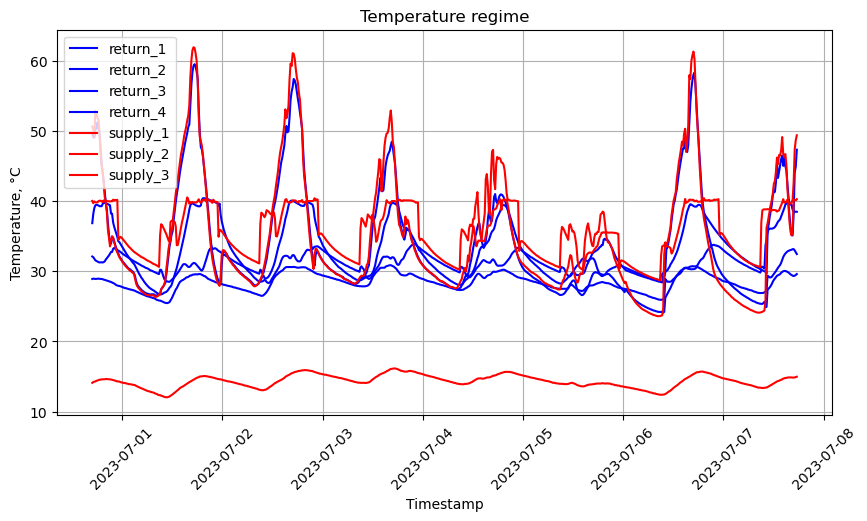

In [12]:
# Visalize temperatures

#Set plot size
fig, axes = plt.subplots(figsize=(10, 5))


# Plot each return column on a separate line
for column in reshaped_df.columns[1:5]:
    plt.plot(reshaped_df['timestamp'], reshaped_df[column], label=column, color='blue')
    
# Plot each supply column on a separate line
for column in reshaped_df.columns[5:8]:
    plt.plot(reshaped_df['timestamp'], reshaped_df[column], label=column, color='red')

plt.xlabel('Timestamp')
plt.ylabel('Temperature, °C')
plt.title('Temperature regime')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [13]:
# View a specific day in more detail

# Specify the specific day
target_day = '2023-07-01'

# Convert the target_day to datetime format
target_day_datetime = pd.to_datetime(target_day)

# Filter data by target day
reshaped_df_only_1jul = reshaped_df[reshaped_df['timestamp'].dt.date == target_day_datetime.date()].reset_index(drop=True)

# Convert the 'timestamp' column to datetime format
reshaped_df_only_1jul['timestamp'] = reshaped_df_only_1jul['timestamp'].dt.strftime('%H:%M:%S')

reshaped_df_only_1jul.head()

,timestamp,return_1,return_2,return_3,return_4,supply_1,supply_2,supply_3
0,00:05:00,27.72,31.40,32.5,33.37,14.12,31.30,34.62
1,00:20:00,27.70,31.22,32.4,33.12,14.10,31.10,34.45
2,00:35:00,27.60,31.02,32.3,32.90,14.07,30.90,34.25
3,00:50:00,27.60,30.87,32.2,32.67,14.05,30.72,34.07
4,01:05:00,27.55,30.70,32.1,32.42,14.00,30.57,33.87


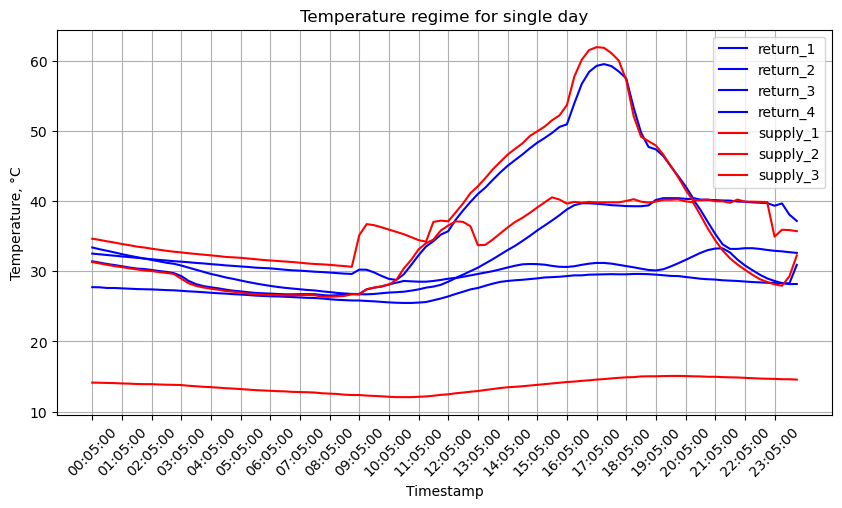

In [14]:
# Visalize specific day

#Set plot size
fig, axes = plt.subplots(figsize=(10, 5))

# Plot each column on a separate line, return
for column in reshaped_df_only_1jul.columns[1:5]:
    plt.plot(reshaped_df_only_1jul['timestamp'], reshaped_df_only_1jul[column], label=column, color='blue')
    
# Plot each column on a separate line, supply
for column in reshaped_df_only_1jul.columns[5:8]:
    plt.plot(reshaped_df_only_1jul['timestamp'], reshaped_df_only_1jul[column], label=column, color='red')

plt.xlabel('Timestamp')
plt.ylabel('Temperature, °C')
plt.title('Temperature regime for single day')
plt.legend()  # Show the legend with column names
plt.xticks(reshaped_df_only_1jul['timestamp'][::4])  # Show every 4th timestamp on the x-axis
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.grid(True)  # Add gridlines if desired
plt.show()

In [15]:
# In the system, there are two main supply lines with equal discharge, and occasionally,
# the values in the database get interchanged or swapped.
# So we can merge temperatures and swap temperatures where it is necessary

In [16]:
# Take a mean temperatures
df_sum = reshaped_df.loc[:,['timestamp', 'return_3', 'return_4', 'supply_2', 'supply_3']]
df_sum['return_new'] = (df_sum['return_3'] + df_sum['return_4'])/2
df_sum['supply_new'] = (df_sum['supply_2'] + df_sum['supply_3'])/2

# Swap where it necessary
df_sum['supply'] = np.where(df_sum['supply_new'] > df_sum['return_new'],
                                df_sum['supply_new'],
                                df_sum['return_new'])
df_sum['return'] = np.where(df_sum['supply_new'] > df_sum['return_new'],
                                df_sum['return_new'],
                                df_sum['supply_new'])

# Lock necessary columns
df_sum = df_sum.loc[:,['timestamp', 'return', 'supply']]

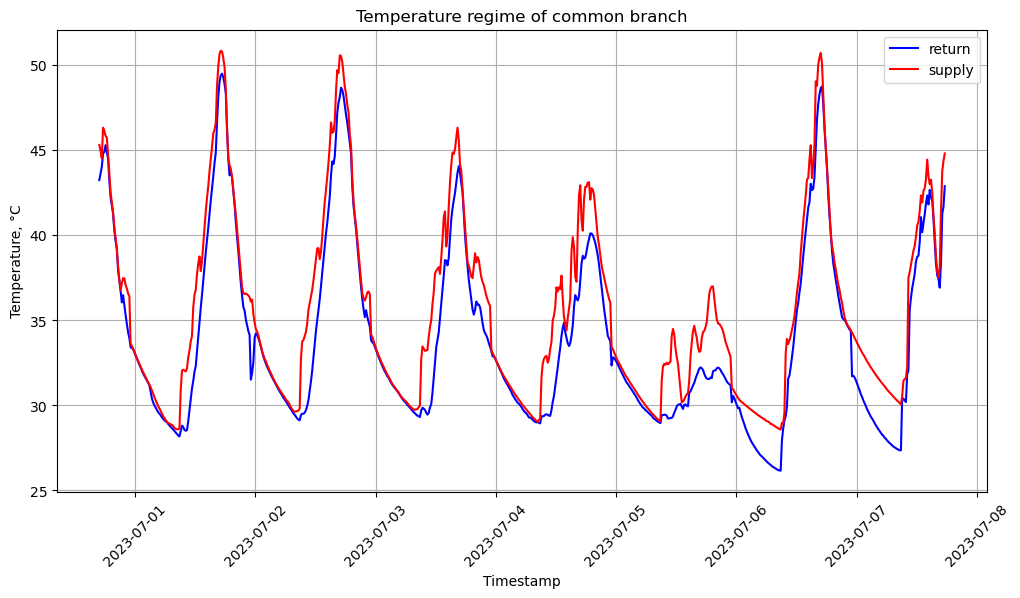

In [17]:
# Visalize common branch

#Set plot size
plt.figure(figsize=(12,6))

# Plotting the new data
plt.plot(df_sum['timestamp'], df_sum['return'], label='return', color='blue')
plt.plot(df_sum['timestamp'], df_sum['supply'], label='supply', color='red')

plt.xlabel('Timestamp')
plt.ylabel('Temperature, °C')
plt.title('Temperature regime of common branch')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [18]:
'''
Params:
    1. Area                   54000    sq m
    2. Hot water cons         0.001     l/s/sqm
    3. Hot water cons total   54      l/s
    
Thermal power formula:
    P = dt*m*Cp
    P - thermal power, kWt
    dt - temperature difference, °C
    m - recirculation rate, l/s
    
'''
m = 54
Cp = 4.182

In [19]:
# Add thermal power column
df_sum['t_power'] = round((df_sum['supply']-df_sum['return'])*m*Cp, 2)
df_sum.head()

,timestamp,return,supply,t_power
0,2023-06-30 16:50:00,43.250,45.320,467.46
1,2023-06-30 17:05:00,43.650,44.985,301.48
2,2023-06-30 17:20:00,44.035,44.525,110.66
3,2023-06-30 17:35:00,44.800,46.335,346.65
4,2023-06-30 17:50:00,44.920,46.150,277.77


In [20]:
# View a specific day in more detail

# Filter data by target day
df_sum_singlday = df_sum[df_sum['timestamp'].dt.date == target_day_datetime.date()].reset_index(drop=True)

# Convert the 'timestamp' column to datetime format
df_sum_singlday['timestamp'] = df_sum_singlday['timestamp'].dt.strftime('%H:%M:%S')

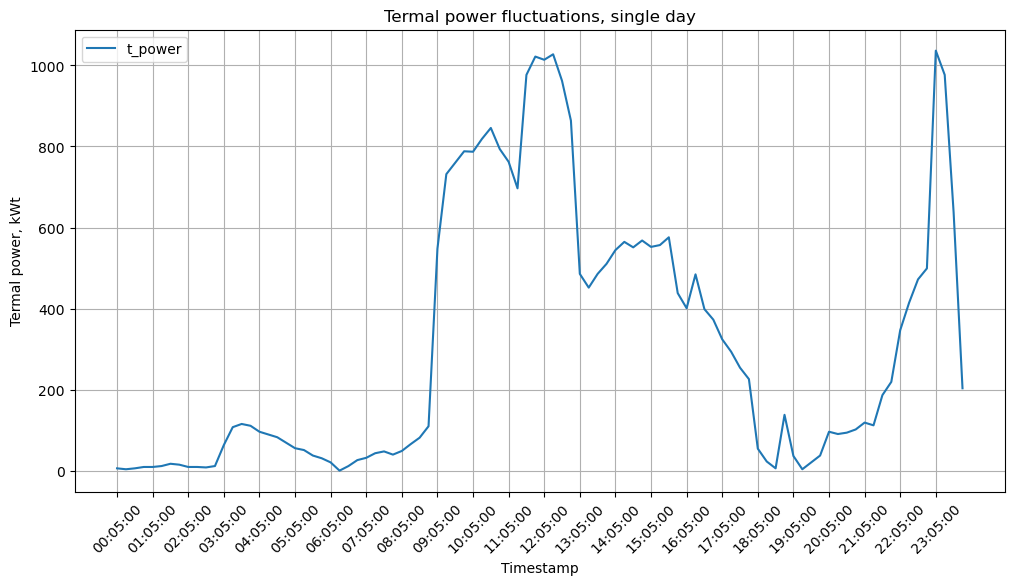

In [21]:
# Visalize thermal power for single day

#Set plot size
plt.figure(figsize=(12,6))

# Plotting the new data
plt.plot(df_sum_singlday['timestamp'], df_sum_singlday['t_power'], label='t_power')

plt.xlabel('Timestamp')
plt.ylabel('Termal power, kWt')
plt.title('Termal power fluctuations, single day')
plt.legend()  
plt.xticks(reshaped_df_only_1jul['timestamp'][::4]) 
plt.xticks(rotation=45) 
plt.grid(True) 
plt.show()

In [22]:
# The primary concern for the system is underheating, which must be addressed by maintaining
# the water temperature between 49 and 60 degrees to prevent the growth of Legionella Bacteria.
# Since the thermal power consumption remains stable, the water discharge rate should be adjusted
# to regulate the temperature and ensure it stays within the desired range.

In [23]:
## Obtain smoothed values of discharging rate

In [24]:
# Group by time in order to obtain mean values during the average day

# Copy dataframe
df_mean = df_sum.copy()

# Leave only time, drop dates
df_mean['timestamp'] = df_mean['timestamp'].dt.strftime('%H:%M:%S')

# Group by timestamp
df_mean_day = df_mean.groupby('timestamp').mean().reset_index()
df_mean_day.head()

,timestamp,return,supply,t_power
0,00:05:00,32.410000,32.914286,113.882857
1,00:20:00,32.242857,32.757857,116.304286
2,00:35:00,32.089286,32.593571,113.882857
3,00:50:00,31.886429,32.432143,123.237143
4,01:05:00,31.692143,32.263571,129.042857


In [25]:
# Calculate the scaling factor to maintain the same daily sum for t_power after smoothing
daily_sum_t_power = df_mean_day['t_power'].sum()
smoothed_daily_sum_t_power = df_mean_day['t_power'].rolling(20, min_periods=1).mean().sum()
scaling_factor = daily_sum_t_power / smoothed_daily_sum_t_power

# Apply the moving average to the t_power column and scale it to maintain the same daily sum
df_mean_day['t_power_smoothed'] = df_mean_day['t_power'].rolling(20, min_periods=1).mean() * scaling_factor

In [26]:
# We have an average heat consumption value that we can use to regulate the pump operation throughout the day.
# To maintain the pump efficiently, we should consider adjusting its power within a certain range based on the 
# temperature of the supply water. If the temperature goes beyond specific limits, the pump's power should be 
# adapted accordingly to match the current consumption.

In [27]:
# Copy dataframe and convert data
df_new = df_mean_day.copy().reset_index(drop=True)
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'], format="%H:%M:%S")
df_new

,timestamp,return,supply,t_power,t_power_smoothed
0,1900-01-01 00:05:00,32.410000,32.914286,113.882857,119.377030
1,1900-01-01 00:20:00,32.242857,32.757857,116.304286,120.646155
2,1900-01-01 00:35:00,32.089286,32.593571,113.882857,120.223113
3,1900-01-01 00:50:00,31.886429,32.432143,123.237143,122.462986
4,1900-01-01 01:05:00,31.692143,32.263571,129.042857,125.024071
...,...,...,...,...,...
91,1900-01-01 22:50:00,33.648571,35.497857,417.620000,338.234595
92,1900-01-01 23:05:00,32.317857,33.697857,311.644286,338.344511
93,1900-01-01 23:20:00,32.428571,33.608571,266.477143,334.590749
94,1900-01-01 23:35:00,32.466429,33.330714,195.178571,326.246202


In [28]:
# Custom function to assign desired temperatures for supply
# Day - 55°C, evening - 50°C, night - 40°C
def assign_desired_temperature(row):
    if row['timestamp'].time() > pd.to_datetime('00:00:00').time()\
    and row['timestamp'].time() < pd.to_datetime('08:00:00').time():
        return 40
    elif row['timestamp'].time() >= pd.to_datetime('08:00:00').time()\
    and row['timestamp'].time() < pd.to_datetime('18:00:00').time():
        return 55
    else:
        return 50

# Apply the custom function to create the 'desired_temperature' column
df_new['supply_new'] = df_new.apply(assign_desired_temperature, axis=1)

# Calculate return
df_new['return_new'] = df_new['supply_new'] - 5

# Convert the 'timestamp' column to datetime format
df_new['timestamp'] = df_new['timestamp'].dt.strftime('%H:%M:%S')

In [29]:
# Add discharge rate, l/s: m = q/dt/Cp
df_new['discharge'] = round(df_new['t_power_smoothed']/5/Cp, 2)
df_new.head()

,timestamp,return,supply,t_power,t_power_smoothed,supply_new,return_new,discharge
0,00:05:00,32.410000,32.914286,113.882857,119.377030,40,35,5.71
1,00:20:00,32.242857,32.757857,116.304286,120.646155,40,35,5.77
2,00:35:00,32.089286,32.593571,113.882857,120.223113,40,35,5.75
3,00:50:00,31.886429,32.432143,123.237143,122.462986,40,35,5.86
4,01:05:00,31.692143,32.263571,129.042857,125.024071,40,35,5.98


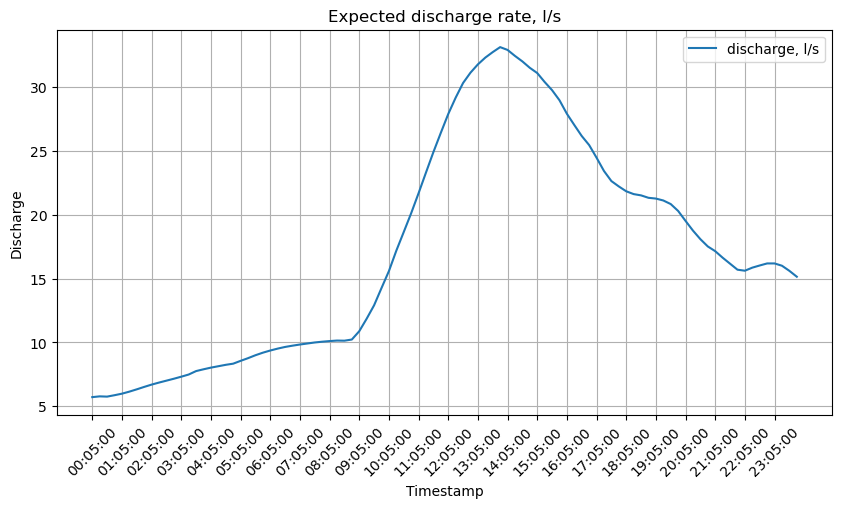

In [30]:
# Visalize expected discharge rate

#Set plot size
plt.figure(figsize=(10,5))

# Plot each column on a separate line
plt.plot(df_new['timestamp'], df_new['discharge'], label='discharge, l/s')

plt.xlabel('Timestamp')
plt.ylabel('Discharge')
plt.title('Expected discharge rate, l/s')
plt.legend()  
plt.xticks(df_new['timestamp'][::4]) 
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()

In [31]:
# To achieve the best consumption optimization, we can create a Machine Learning (ML) model
# that takes into account factors such as date, weather, and other relevant variables.
# As the model is built on a larger dataset with numerous observations, its predictive
# capabilities are likely to improve significantly.

In [32]:
# Read CSV-file with weather
path_w = 'weather_2023-07.csv'
data_w = pd.read_csv(path_w, parse_dates=['datetime'])

In [33]:
# New discharge column for every observation
df_new1 = df_sum.copy()
df_new1['discharge'] = round(df_sum['t_power']/5/Cp, 2)

In [34]:
# Filter columns to leave columns necessary for ML model
col_filter_weather = ['datetime', 'temp', 'humidity', 'cloudcover']
col_filter_dhw = ['timestamp', 'discharge']
df_weather = data_w[col_filter_weather].reset_index(drop=True)
df_dhw = df_new1[col_filter_dhw].rename(columns={"timestamp": "datetime"}).reset_index(drop=True)

# Floor datetime by hours in order to fit datasets
df_weather['datetime'] = df_weather['datetime'].dt.floor('H')
df_dhw['datetime'] = df_dhw['datetime'].dt.floor('H')

# Merge
df_merged = pd.merge(df_dhw, df_weather, how='left', on='datetime')
df_merged.sort_values('datetime', ascending=True)

# Assign actuale timestamps
df_merged['datetime'] = df_new1['timestamp']
df_merged

,datetime,discharge,temp,humidity,cloudcover
0,2023-06-30 16:50:00,22.36,25.6,58.22,66.7
1,2023-06-30 17:05:00,14.42,25.6,59.81,37.6
2,2023-06-30 17:20:00,5.29,25.6,59.81,37.6
3,2023-06-30 17:35:00,16.58,25.6,59.81,37.6
4,2023-06-30 17:50:00,13.28,25.6,59.81,37.6
...,...,...,...,...,...
669,2023-07-07 16:35:00,12.96,27.1,54.96,25.0
670,2023-07-07 16:50:00,32.83,27.1,54.96,25.0
671,2023-07-07 17:05:00,27.00,28.2,51.83,27.9
672,2023-07-07 17:20:00,29.00,28.2,51.83,27.9


In [35]:
# Prepare data for modeling

# Separate months, days, hours, minutes and dayweeks
df_merged['month'] = df_merged['datetime'].dt.month
df_merged['day'] = df_merged['datetime'].dt.day
df_merged['hour'] = df_merged['datetime'].dt.hour
df_merged['minute'] = df_merged['datetime'].dt.minute
df_merged['dayofweek'] = df_merged['datetime'].dt.dayofweek

# Drop datetime
df = df_merged.drop('datetime', axis=1)
df

,discharge,temp,humidity,cloudcover,month,day,hour,minute,dayofweek
0,22.36,25.6,58.22,66.7,6,30,16,50,4
1,14.42,25.6,59.81,37.6,6,30,17,5,4
2,5.29,25.6,59.81,37.6,6,30,17,20,4
3,16.58,25.6,59.81,37.6,6,30,17,35,4
4,13.28,25.6,59.81,37.6,6,30,17,50,4
...,...,...,...,...,...,...,...,...,...
669,12.96,27.1,54.96,25.0,7,7,16,35,4
670,32.83,27.1,54.96,25.0,7,7,16,50,4
671,27.00,28.2,51.83,27.9,7,7,17,5,4
672,29.00,28.2,51.83,27.9,7,7,17,20,4


In [36]:
# Import ML models and peformance metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [37]:
# Split dataset into training and testing sets
X=df.drop(['discharge'], axis=1)
y=df['discharge']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [38]:
# Linear regression modeling
linreg = LinearRegression()
linreg.fit(X_train , y_train)
y_pred = linreg.predict(X_test)

In [39]:
# Decision tree modeling
dt = DecisionTreeRegressor()
dt.fit(X_train , y_train)
y_pred_dt = dt.predict(X_test)

In [40]:
# Random forest modeling
rf = RandomForestRegressor()
rf.fit(X_train , y_train)
y_pred_rf = rf.predict(X_test)

In [41]:
# Calculate LinearRegression evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print('LinearRegression, Mean Squared Error (MSE):', mse)
print('LinearRegression, Root Mean Squared Error (RMSE):', rmse)
print('LinearRegression, Mean Absolute Error (MAE):', mae)
print('LinearRegression, R-squared (R^2) Score:', r2)

LinearRegression, Mean Squared Error (MSE): 241.05239903981385
LinearRegression, Root Mean Squared Error (RMSE): 15.525862263971488
LinearRegression, Mean Absolute Error (MAE): 13.056770760517448
LinearRegression, R-squared (R^2) Score: 0.08585447695620041


In [42]:
# Calculate DecisionTree evaluation metrics
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

# Print the evaluation metrics
print('DecisionTree, Mean Squared Error (MSE):', mse_dt)
print('DecisionTree, Root Mean Squared Error (RMSE):', rmse_dt)
print('DecisionTree,  Mean Absolute Error (MAE):', mae_dt)
print('DecisionTree, R-squared (R^2) Score:', r2_dt)

DecisionTree, Mean Squared Error (MSE): 65.52297810650889
DecisionTree, Root Mean Squared Error (RMSE): 8.094626495800092
DecisionTree,  Mean Absolute Error (MAE): 4.040177514792899
DecisionTree, R-squared (R^2) Score: 0.7515165278124076


In [43]:
# Calculate evaluation metrics RandomForestRegressor
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print('RandomForestRegressor, Mean Squared Error (MSE):', mse_rf)
print('RandomForestRegressor, Root Mean Squared Error (RMSE):', rmse_rf)
print('RandomForestRegressor, Mean Absolute Error (MAE):', mae_rf)
print('RandomForestRegressor, R-squared (R^2) Score:', r2_rf)

RandomForestRegressor, Mean Squared Error (MSE): 48.69806099041412
RandomForestRegressor, Root Mean Squared Error (RMSE): 6.978399600941044
RandomForestRegressor, Mean Absolute Error (MAE): 3.8766355029585755
RandomForestRegressor, R-squared (R^2) Score: 0.815321836195672


In [44]:
RMSE = {'LinearRegression': [rmse.round(1), mae.round(1), r2.round(2)],
        'DecisionTreeRegressor': [rmse_dt.round(1), mae_dt.round(1), r2_rf.round(2)],
        'RandomForestRegressor': [rmse_rf.round(1), mae_rf.round(1), r2_rf.round(2)]}
best_RMSE = pd.DataFrame(RMSE, index=['RMSE', 'MAE', 'R^2'])
print('Mean discharge value: ', df['discharge'].mean())
best_RMSE

Mean discharge value:  17.108026706231456


,LinearRegression,DecisionTreeRegressor,RandomForestRegressor
RMSE,15.50,8.10,7.00
MAE,13.10,4.00,3.90
R^2,0.09,0.82,0.82


In [45]:
# The Random Forest model demonstrates good performance of 6.7 RMSE, outperforming the Decision Tree Regressor
# models, but both with a notable R2 score of 0.83 in predicting the discharge rate. On the other hand, the
# Linear Regression model exhibits unsatisfactory performance, with an R2 score of 0.09 and notably high
# RMSE and MAE values, indicating its limited predictive capability and higher error rates in comparison.